In [33]:
import torch
import torchvision

import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

from tqdm.auto import tqdm

from timeit import default_timer as timer

print(torch.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"

2.2.1+cu121


In [25]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("already exists")
else:
  print("downloading")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

downloading


In [26]:
from helper_functions import accuracy_fn

In [4]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)


100%|██████████| 9912422/9912422 [00:00<00:00, 91667922.50it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29494933.97it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24554564.81it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5261123.66it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [6]:
len(train_data), len(test_data)

(60000, 10000)

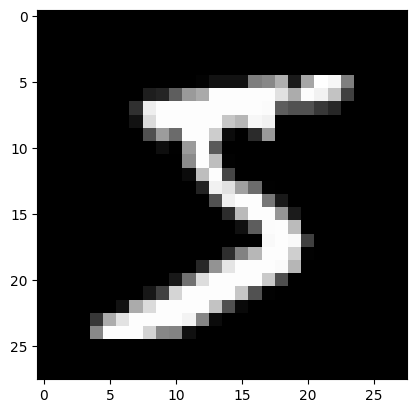

In [14]:
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap="gray")

In [16]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [17]:
class_names[label]

'5 - five'

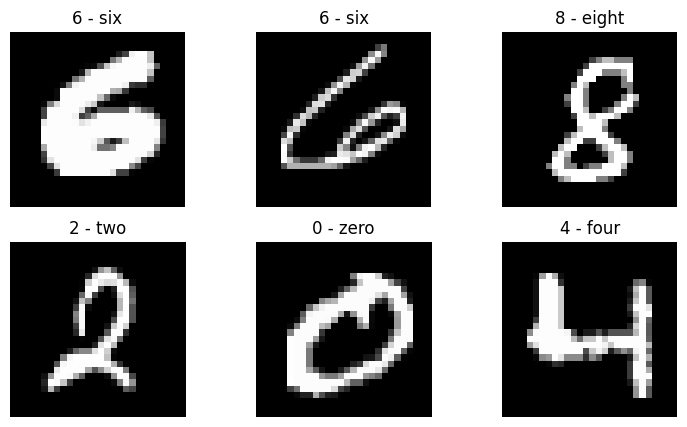

In [20]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 5))
rows, cols = 2, 3
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [22]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [23]:
class MNISTModelV0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [24]:
model_0 = MNISTModelV0(input_shape=1,
                       hidden_units=10,
                       output_shape=len(class_names)).to(device)

In [27]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  train_loss, train_acc = 0, 0

  model.train()

  for batch, (X,y) in enumerate(data_loader):
    model.train()

    X, y = X.to(device), y.to(device)
    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /=len(data_loader)
  train_acc /=len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")


In [29]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):

  test_loss, test_acc = 0, 0

  model.eval()

  with torch.inference_mode():
    for X_test, y_test in data_loader:
      X_test, y_test = X_test.to(device), y_test.to(device)

      test_pred = model(X_test)

      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test loss: {test_loss:.5f} | Test loss: {test_acc:.2f}%\n")


In [31]:
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  total_time = end - start
  print(f"total time on {device}: {total_time:.3f}")
  return total_time

In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lr=0.1,
                            params=model_0.parameters())

In [35]:
torch.manual_seed(42)

train_time_start = timer()

epochs = 5

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")

  train_step(model=model_0,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_0,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end = timer()
total_train_time_model_0 = print_train_time(start=train_time_start,
                                            end=train_time_end,
                                            device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
Train loss: 0.40891 | Train acc: 85.91%
Test loss: 0.09532 | Test loss: 97.13%

Epoch: 1
Train loss: 0.09362 | Train acc: 97.12%
Test loss: 0.06601 | Test loss: 97.94%

Epoch: 2
Train loss: 0.07429 | Train acc: 97.69%
Test loss: 0.05475 | Test loss: 98.18%

Epoch: 3
Train loss: 0.06418 | Train acc: 98.00%
Test loss: 0.06459 | Test loss: 98.05%

Epoch: 4
Train loss: 0.05730 | Train acc: 98.27%
Test loss: 0.05718 | Test loss: 98.12%

total time on cpu: 287.891


In [36]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)

      pred_logits = model(sample)

      pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [40]:
import random
random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=6):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

In [41]:
pred_probs = make_predictions(model=model_0,
                              data=test_samples)
pred_probs[:2]

tensor([[7.0098e-10, 5.3741e-07, 9.9974e-01, 1.4912e-05, 6.5474e-15, 1.2767e-11,
         4.0192e-11, 9.9652e-07, 2.4510e-04, 3.0906e-09],
        [7.8976e-06, 9.8632e-01, 3.0247e-06, 2.7252e-05, 1.7928e-04, 3.6026e-03,
         1.6598e-03, 2.5861e-04, 6.9464e-03, 9.9894e-04]])

In [43]:
pred_classes=pred_probs.argmax(dim=1)
pred_classes

tensor([2, 1, 2, 4, 6, 6])

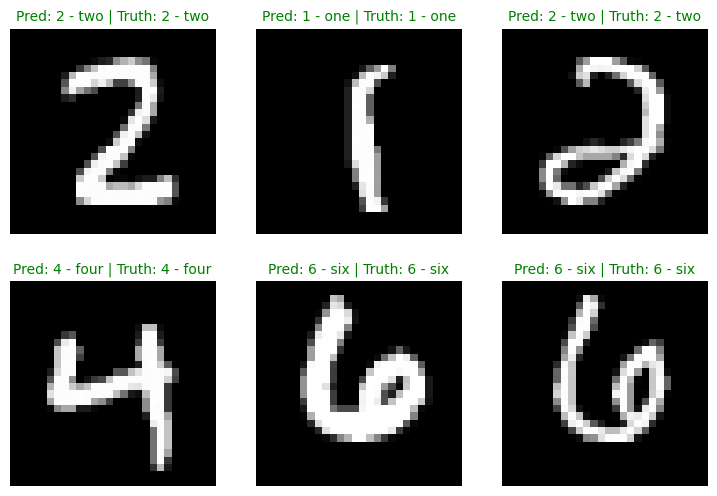

In [44]:
plt.figure(figsize=(9, 6))
nrows = 2
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)

  plt.imshow(sample.squeeze(), cmap="gray")

  pred_label = class_names[pred_classes[i]]


  truth_label = class_names[test_labels[i]]

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False)

In [47]:
from tqdm.auto import tqdm

y_preds = []
model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    X, y = X.to(device), y.to(device)

    y_logits = model_0(X)

    y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())

# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([7, 2, 1, 0, 4, 1, 8, 9, 8, 9])

In [45]:
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(",")[1]) >= 19, "mlxtend version should be 19 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.7 MB/s eta 0:00:00
mlxtend version: 0.23.1


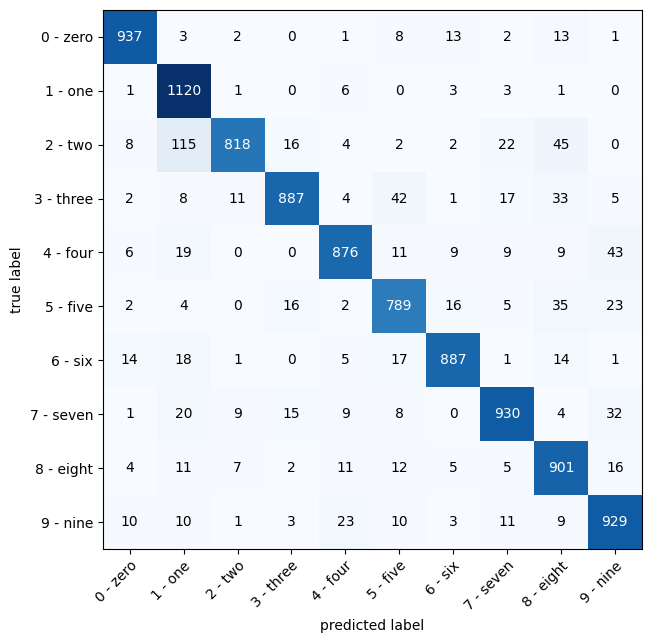

In [48]:
import mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)

)

In [66]:
test_image_RGB = torch.rand([1, 3, 64, 64])

torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=2,
                       stride=1,
                       padding=0)
conv_output = conv_layer(test_image_RGB)
conv_output.shape

torch.Size([1, 10, 63, 63])